# Deep Q-Network CNN implementation

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

In [1]:
import gym
import random
import numpy as np
import torch
import cv2
import utils
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ENV_NAME = "BreakoutNoFrameskip-v4"

# Preprocessing

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


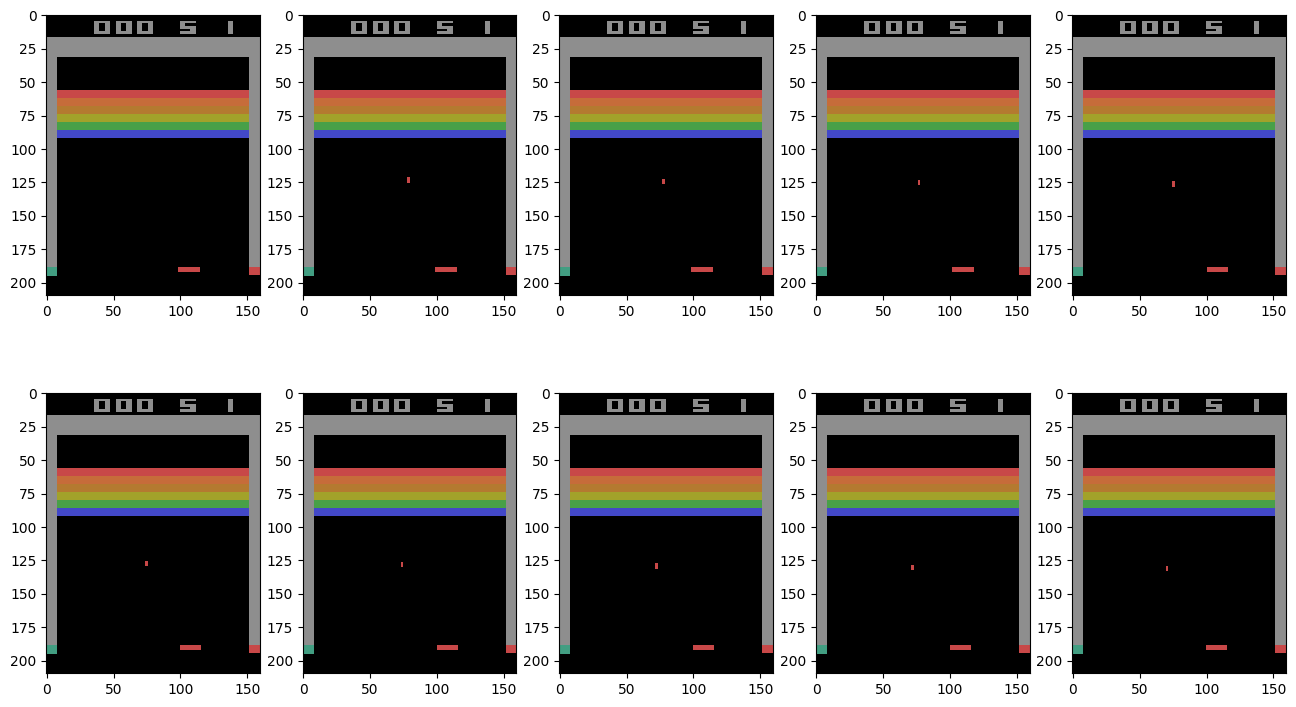

In [3]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render("rgb_array"))
        env.step(env.action_space.sample())
plt.show()

### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

In [4]:
from gym.core import ObservationWrapper
from gym.spaces import Box


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return (rgb * np.array(channel_weights)).mean(axis=2)[np.newaxis, :, :]

    def observation(self, img):
        """what happens to each observation"""
        crop = img[55:, 10:, :]
        resized = cv2.resize(crop, (64, 64))
        gs = self._to_gray_scale(resized)
        return gs.astype(np.float32) / 255

Formal tests seem fine. Here's an example of what you'll get.


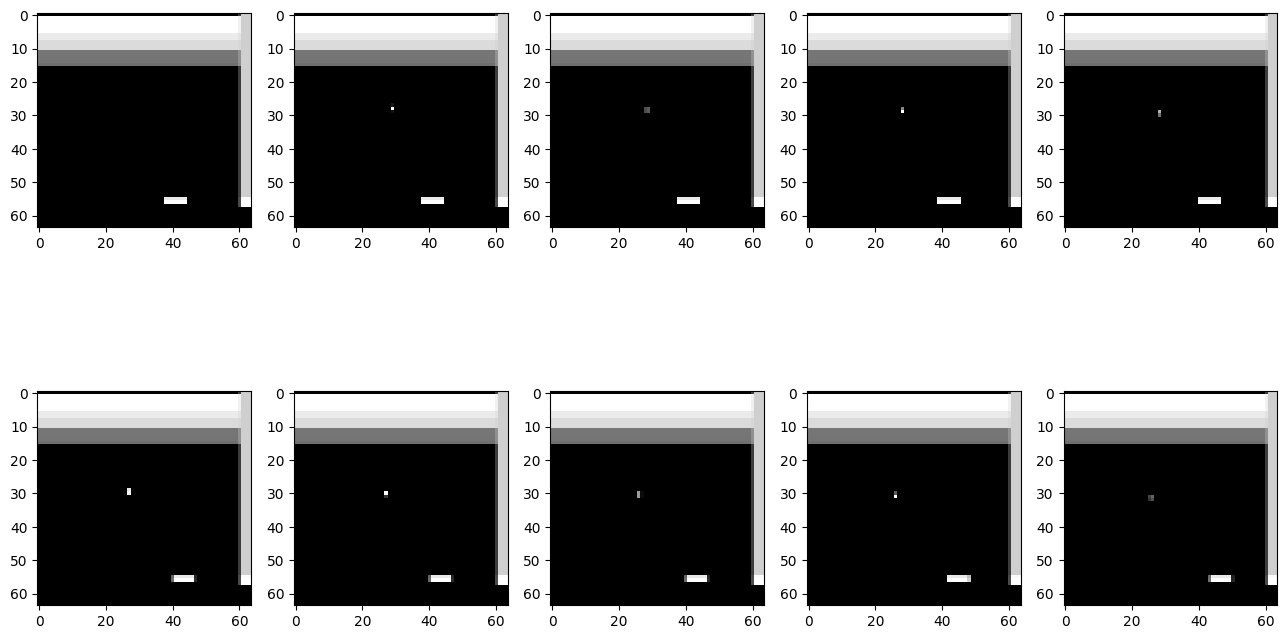

In [6]:
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

# test observation
assert (
    obs.ndim == 3
), "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == "float32"
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <= 1, "convert image pixels to [0,1] range"
assert np.max(obs) > 1.0 / 256, "you probably divided on 256 twice"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation="none", cmap="gray")
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

# Wrapping

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [5]:
%load_ext autoreload
%autoreload 2
import atari_wrappers


def PrimaryAtariWrap(env, clip_rewards=True):
    assert "NoFrameskip" in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images.

In [6]:
from framebuffer import FrameBuffer


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order="pytorch")
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

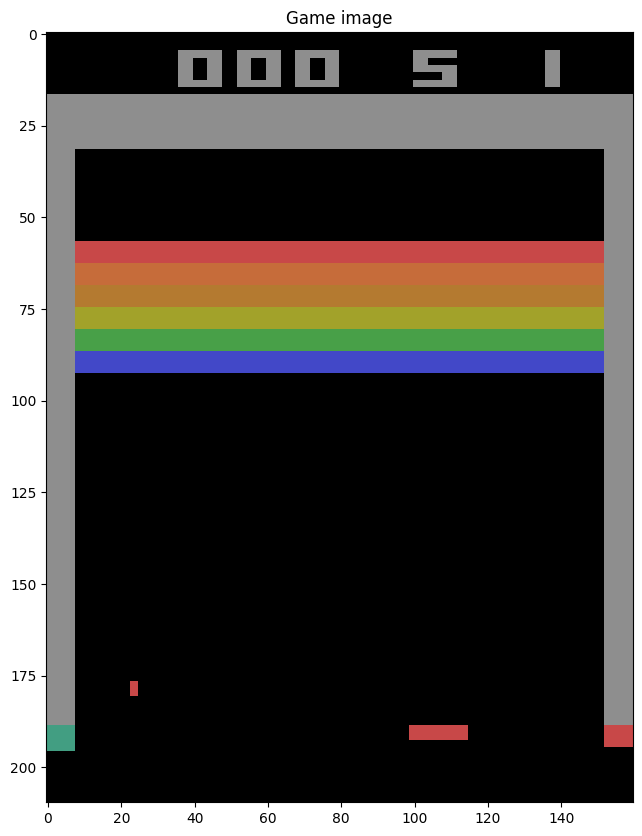

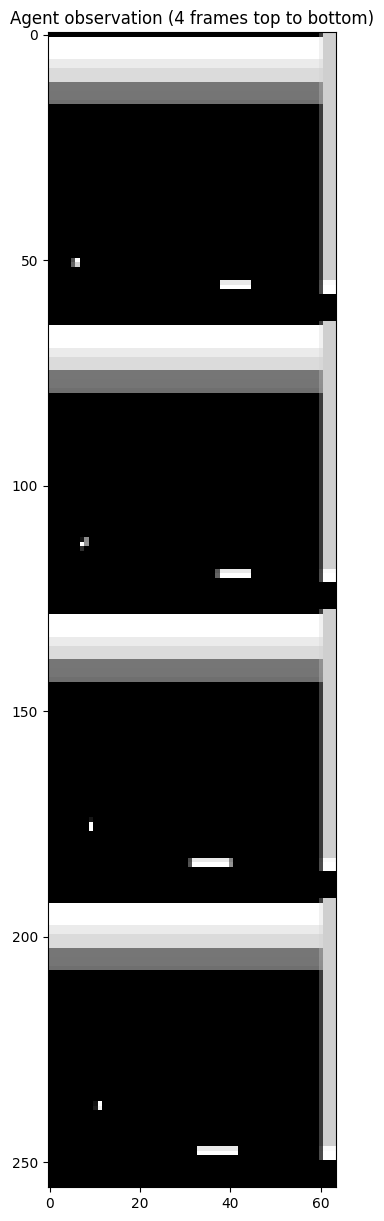

In [10]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12, 10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15, 15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap="gray")
plt.show()

# DQN as it is

### Building a network


<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png width=640>

In [7]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

device(type='cuda')

In [8]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [9]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # conv2d_size_out(conv2d_size_out(conv2d_size_out(64, 3, 2), 3, 2), 3, 2)
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(3136, 256),
            nn.Linear(256, n_actions),
        )

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        qvalues = self.net(state_t)

        assert (
            len(qvalues.shape) == 2
            and qvalues.shape[0] == state_t.shape[0]
            and qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy."""
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1 - epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [10]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [10]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward."""
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = (
                qvalues.argmax(axis=-1)[0]
                if greedy
                else agent.sample_actions(qvalues)[0]
            )
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [12]:
evaluate(env, agent, n_games=1)

0.0

# Experience Replay
There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: Experience Replay. The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=640>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [11]:
from queue import Queue


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = Queue(maxsize=size)
        self._maxsize = size

    def __len__(self):
        # return len(self._storage)
        return self._storage.qsize()

    def add(self, obs_t, action, reward, obs_tp1, done):
        """
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        """
        data = (obs_t, action, reward, obs_tp1, done)
        #   storage = self._storage
        #   maxsize = self._maxsize

        if self.__len__() == self._maxsize:
            self._storage.get()

        self._storage.put(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idx = np.random.choice(self.__len__(), size=batch_size)
        # randomly generate batch_size integers
        # to be used as indexes of samples

        self.batch = np.array(list(self._storage.queue))[idx]
        # collect <s,a,r,s',done> for each index

        return (
            np.stack(self.batch[:, 0], axis=0).astype(np.float32),
            self.batch[:, 1].astype(np.float32),
            self.batch[:, 2].astype(np.float32),
            np.stack(self.batch[:, 3], axis=0).astype(np.float32),
            self.batch[:, 4].astype(np.float32),
        )
        # <states>, <actions>, <rewards>, <next_states>, <is_done>

In [55]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert (
    len(exp_replay) == 10
), "experience replay size should be 10 because that's what maximum capacity is"

/tmp/ipykernel_2826570/2941548265.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.batch = np.array(list(self._storage.queue))[idx]


In [12]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.


    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for t in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        new_s, r, done, _ = env.step(action)
        sum_rewards += r

        # print(s, new_s)
        exp_replay.add(s, action, r, new_s, done)

        if done:
            s = env.reset()
        else:
            s = new_s

    return sum_rewards, s

In [56]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, (
    "play_and_record should have added exactly 1000 steps, "
    "but instead added %i" % len(exp_replay)
)
is_dones = list(zip(*exp_replay._storage.queue))[-1]

assert 0 < np.mean(is_dones) < 0.1, (
    "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."
    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"
    % (np.mean(is_dones), len(exp_replay))
)

for _ in range(100):
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
    ) = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,
    ), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,
    ), "rewards batch should have shape (10,) but is instead %s" % str(
        reward_batch.shape
    )
    assert is_done_batch.shape == (
        10,
    ), "is_done batch should have shape (10,) but is instead %s" % str(
        is_done_batch.shape
    )
    assert [
        int(i) in (0, 1) for i in is_dones
    ], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch
    ], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


/tmp/ipykernel_2826570/2941548265.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.batch = np.array(list(self._storage.queue))[idx]


# Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png width=640>

In [16]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot \max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.



In [13]:
def compute_td_loss(
    states,
    actions,
    rewards,
    next_states,
    is_done,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=False,
    device=device,
):
    """Compute td loss using torch operations only. Use the formulae above."""
    states = torch.tensor(
        states, device=device, dtype=torch.float
    )  # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(
        actions, device=device, dtype=torch.long
    )  # shape: [batch_size]
    rewards = torch.tensor(
        rewards, device=device, dtype=torch.float
    )  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype("float32"), device=device, dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    # print(predicted_next_qvalues)

    # compute V*(next_states) using predicted next q-values
    next_state_values, idxes = predicted_next_qvalues.max(axis=1)

    #    print(next_state_values)

    assert (
        next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0]
    ), "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    assert (
        target_qvalues_for_actions.requires_grad == False
    ), "do not send gradients to target!"

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [38]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10
)

loss = compute_td_loss(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=True,
)
loss.backward()

assert (
    loss.requires_grad and tuple(loss.data.size()) == ()
), "you must return scalar loss - mean over batch"
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "loss must be differentiable w.r.t. network weights"
assert np.all(
    next(target_network.parameters()).grad is None
), "target network should not have grads"

/tmp/ipykernel_2769673/2941548265.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.batch = np.array(list(self._storage.queue))[idx]


# Main loop

It's time to put everything together and see if it learns anything.

In [126]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [19]:
seed = 0xAB0BA
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [20]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [19]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print(
            """
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
        )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [20]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [21]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

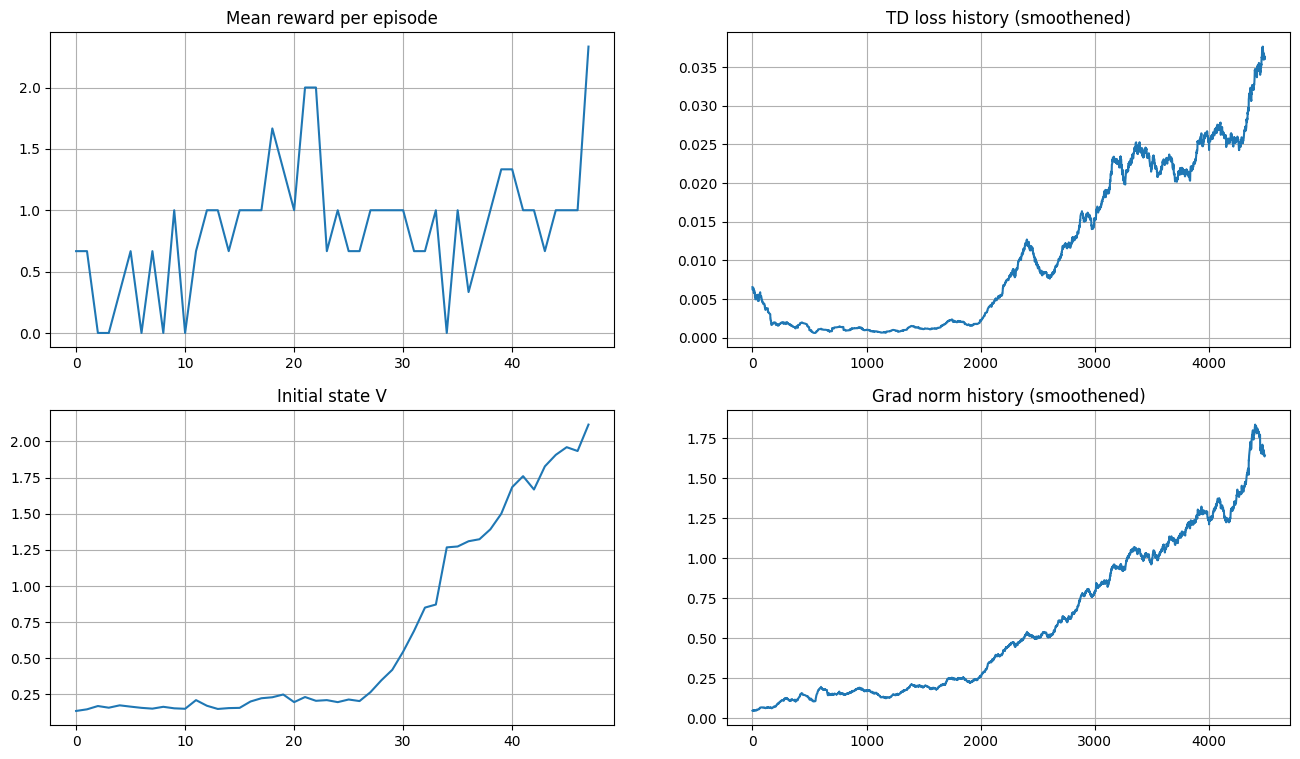

  5%|▍         | 140000/3000001 [50:51<17:18:57, 45.88it/s]


In [54]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print("less that 100 Mb RAM available, freezing")
        print("make sure everything is ok and make KeyboardInterrupt to continue")
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
    ) = exp_replay.sample(batch_size)

    loss = compute_td_loss(
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        agent,
        target_network,
        gamma=0.99,
        check_shapes=True,
    )  # < compute TD loss >

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        path = "agent_" + str(step) + ".tar"
        torch.save({"agent_state_dict": agent.state_dict()}, path)
        # eval the agent
        cur_mean_reward = evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000
        )
        mean_rw_history.append(cur_mean_reward)
        initial_state_q_values = agent.get_qvalues([make_env(seed=step).reset()])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

        if cur_mean_reward > 2:
            break

Final scoring is done on a whole episode with all 5 lives.

In [55]:
final_score = (
    evaluate(
        make_env(clip_rewards=False, seed=9),
        agent,
        n_games=30,
        greedy=True,
        t_max=10 * 1000,
    )
    * n_lives
)
print("final score:", final_score)
assert final_score > 10, "not as cool as DQN can"
print("Cool!")

final score: 11.0
Cool!


# Record a video

In [57]:
# record sessions
import gym.wrappers

env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [
    evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)
]
env_monitor.close()

# Let's have a closer look at this 

If average episode score is below 200 using all 5 lives, then probably DQN has not converged fully. But anyway let's make a more complete record of an episode.

In [21]:
checkpoint = torch.load("agent_140000.tar", map_location=device)
agent.load_state_dict(checkpoint["agent_state_dict"])

<All keys matched successfully>

In [22]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print("total reward for life:", np.sum(record["rewards"]))
for key in record:
    print(key)

total reward for life: 2.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


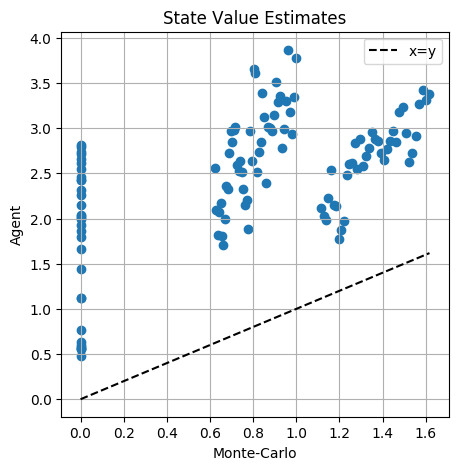

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record["v_mc"], record["v_agent"])
ax.plot(
    sorted(record["v_mc"]), sorted(record["v_mc"]), "black", linestyle="--", label="x=y"
)

ax.grid()
ax.legend()
ax.set_title("State Value Estimates")
ax.set_xlabel("Monte-Carlo")
ax.set_ylabel("Agent")

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

In [22]:
from utils import play_and_log_episode, img_by_obs

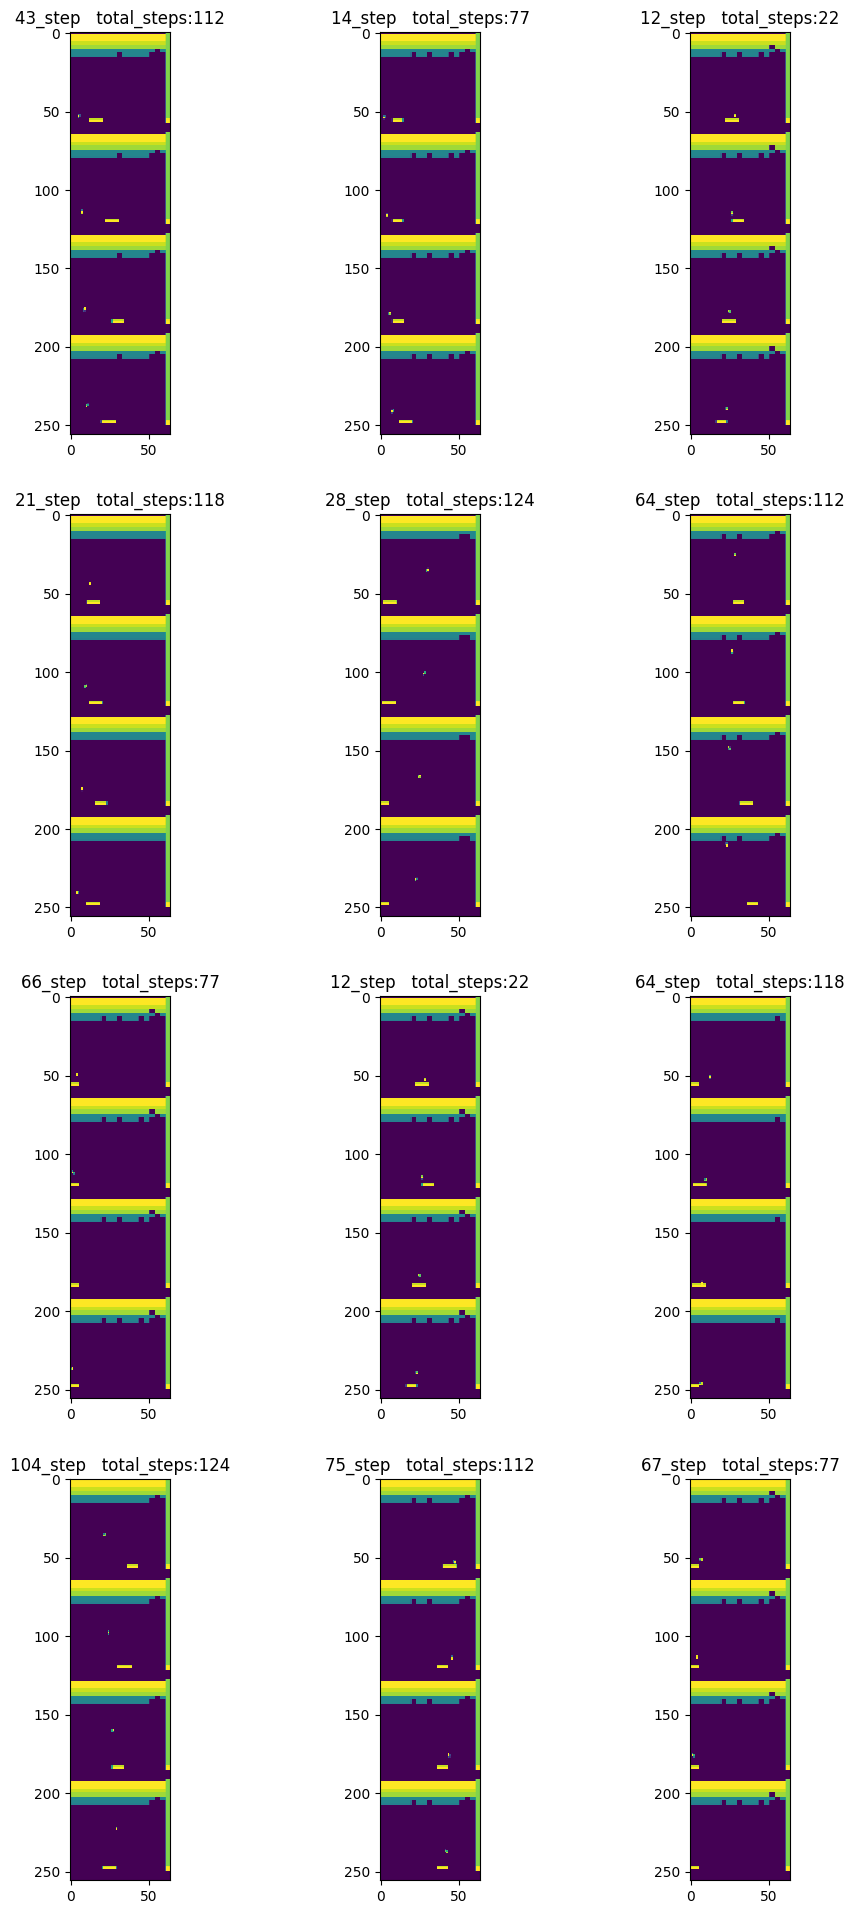

In [68]:
n_cols = 3
n_rows = 4
fig = plt.figure(figsize=(12, 24))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)

        episod = play_and_log_episode(env, agent)

        if row == 0:
            idx = np.argmax(episod["q_spreads"])
            spr_state = episod["states"][idx]
        elif row == 1:
            idx = np.argmin(episod["q_spreads"])
            spr_state = episod["states"][idx]
        elif row == 2:
            idx = np.argmax(episod["td_errors"])
            spr_state = episod["states"][idx]
        elif row == 3:
            idx = np.argmax(np.abs(episod["v_mc"] - episod["v_agent"]))
            spr_state = episod["states"][idx]

        img = img_by_obs(spr_state, (4, 64, 64))
        ax.imshow(img)
        plt.subplots_adjust(hspace=0.2, wspace=0)
        ax.title.set_text(
            str(idx) + "_step   " + "total_steps:{}".format(len(episod["states"]))
        )
        # env.step(env.action_space.sample())
plt.show()

# Double DQN

In [79]:
def compute_td_loss_ddqn(
    states,
    actions,
    rewards,
    next_states,
    is_done,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=False,
    device=device,
):
    """Compute td loss using torch operations only. Use the formulae above."""
    states = torch.tensor(
        states, device=device, dtype=torch.float
    )  # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(
        actions, device=device, dtype=torch.long
    )  # shape: [batch_size]
    rewards = torch.tensor(
        rewards, device=device, dtype=torch.float
    )  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype("float32"), device=device, dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    # change next q values to agent computation
    with torch.no_grad():
        predicted_next_qvalues = agent(next_states)
        predicted_next_qvalues_target = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    # print(predicted_next_qvalues)
    # print(predicted_next_qvalues_target)
    # print(rewards)

    # computing argmax for agent
    argmaxes = predicted_next_qvalues.argmax(axis=1)

    # computing them for target network
    next_state_values = (
        torch.gather(predicted_next_qvalues_target, 1, argmaxes.unsqueeze(1))
    ).squeeze(1)

    assert next_state_values[0] == (predicted_next_qvalues_target[0][argmaxes[0]])

    #    print(next_state_values)

    assert (
        next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0]
    ), "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    assert (
        target_qvalues_for_actions.requires_grad == False
    ), "do not send gradients to target!"

    #  print(predicted_qvalues_for_actions)
    #  print(target_qvalues_for_actions)
    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

In [80]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10
)

loss = compute_td_loss_ddqn(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=True,
)
loss.backward()

assert (
    loss.requires_grad and tuple(loss.data.size()) == ()
), "you must return scalar loss - mean over batch"
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "loss must be differentiable w.r.t. network weights"
assert np.all(
    next(target_network.parameters()).grad is None
), "target network should not have grads"

/tmp/ipykernel_2824112/2941548265.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.batch = np.array(list(self._storage.queue))[idx]


In [66]:
seed = 0xAB0BA
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [67]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [68]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print(
            """
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
        )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [69]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [70]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

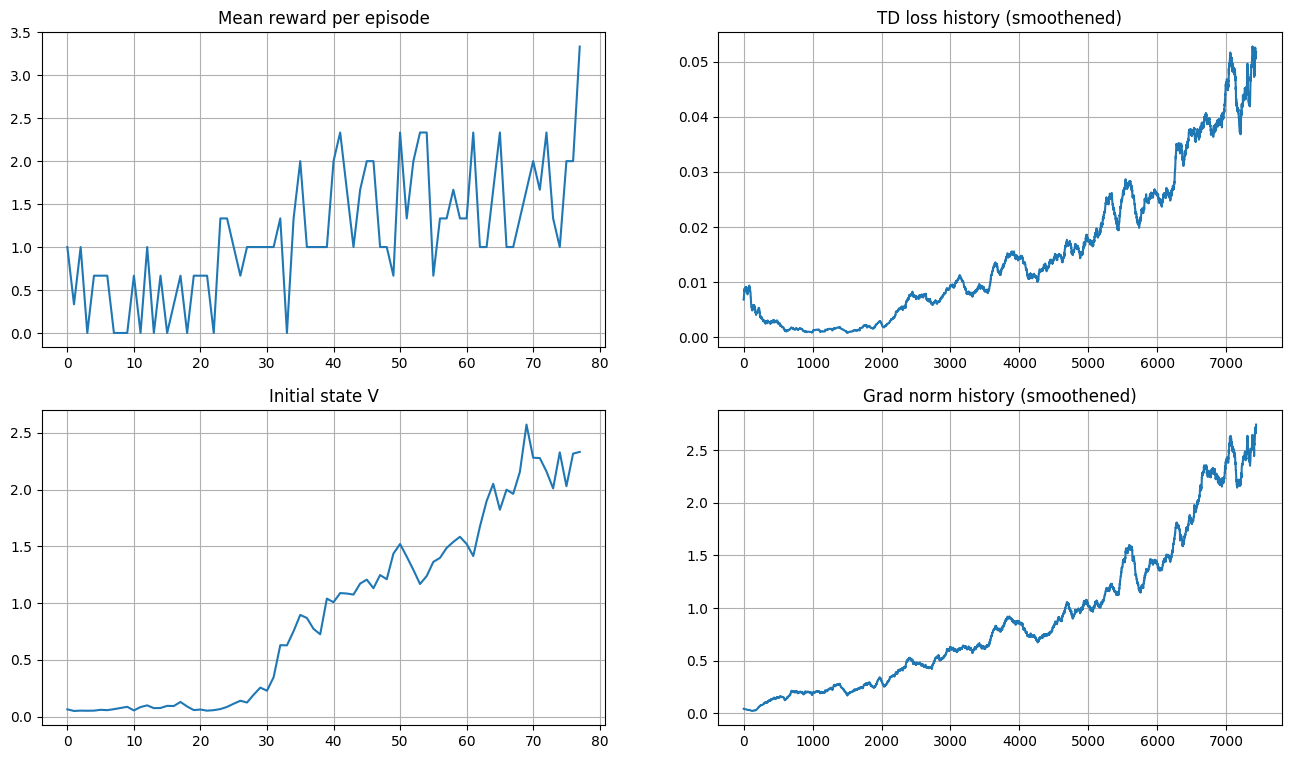

  6%|▌         | 175000/3000001 [1:06:22<17:51:32, 43.94it/s]

best model at path:DDQN_agent_175000.tar


In [87]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print("less that 100 Mb RAM available, freezing")
        print("make sure everything is ok and make KeyboardInterrupt to continue")
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
    ) = exp_replay.sample(batch_size)

    loss = compute_td_loss_ddqn(
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        agent,
        target_network,
        gamma=0.99,
        check_shapes=True,
    )  # < compute TD loss >

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        path = "DDQN_agent_" + str(step) + ".tar"
        torch.save({"agent_state_dict": agent.state_dict()}, path)
        # eval the agent
        cur_mean_reward = evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000
        )
        mean_rw_history.append(cur_mean_reward)
        initial_state_q_values = agent.get_qvalues([make_env(seed=step).reset()])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

        if cur_mean_reward > 3:
            print("best model at path:" + path)
            break

In [88]:
final_score = (
    evaluate(
        make_env(clip_rewards=False, seed=9),
        agent,
        n_games=30,
        greedy=True,
        t_max=10 * 1000,
    )
    * n_lives
)
print("final score:", final_score)
assert final_score > 10, "not as cool as DQN can"
print("Cool!")

final score: 18.0
Cool!


# Prioretized Replay

In [70]:
from prioritized_sampler import PrioritizedSampler


class PrioretizedReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._maxsize = size
        self.sampler = PrioritizedSampler(size)

        state_size = (4, 64, 64)
        action_size = 4

        # я слегка подсматривал сюда https://github.com/Howuhh/prioritized_experience_replay
        self.state = np.empty((size, *state_size), dtype=np.float32)
        self.action = np.empty((size), dtype=np.int8)
        self.reward = np.empty(size, dtype=np.float32)
        self.next_state = np.empty((size, *state_size), dtype=np.float32)
        self.done = np.empty(size, dtype=np.int8)

        self.index = 0
        self.size = 0

        self.unupdated_indices = []

    def __len__(self):
        # return len(self._storage)
        return self.size

    def add(self, obs_t, action, reward, obs_tp1, done):
        """
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        """
        data = (obs_t, action, reward, obs_tp1, done)

        self.state[self.index] = obs_t
        self.action[self.index] = action
        self.reward[self.index] = reward
        self.next_state[self.index] = obs_tp1
        self.done[self.index] = done

        self.sampler.update_priorities(
            np.array([self.index]), np.array([self.sampler.max_priority])
        )
        self.unupdated_indices.append(self.index)

        self.index = (self.index + 1) % self._maxsize

        self.size = min(self.size + 1, self._maxsize)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        indices, weights = self.sampler.sample_indices(batch_size)

        self.batch = (
            self.state[indices],
            self.action[indices],
            self.reward[indices],
            self.next_state[indices],
            self.done[indices],
            weights,
            indices,
        )
        # collect <s,a,r,s',done> for each index

        return self.batch

    def update_priorities(self, indices, priorities):
        self.sampler.update_priorities(indices, priorities)


%autoreload 2

In [71]:
exp_replay = PrioretizedReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    weights,
    indices,
) = exp_replay.sample(5)

assert (
    len(exp_replay) == 10
), "experience replay size should be 10 because that's what maximum capacity is"

In [73]:
def compute_td_loss(
    states,
    actions,
    rewards,
    next_states,
    is_done,
    agent,
    target_network,
    weights,
    gamma=0.99,
    check_shapes=False,
    device=device,
):
    """Compute td loss using torch operations only. Use the formulae above."""
    states = torch.tensor(
        states, device=device, dtype=torch.float
    )  # shape: [batch_size, *state_shape]

    weights = torch.tensor(weights, device=device, dtype=torch.float)

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(
        actions, device=device, dtype=torch.long
    )  # shape: [batch_size]
    rewards = torch.tensor(
        rewards, device=device, dtype=torch.float
    )  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype("float32"), device=device, dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    # print(predicted_next_qvalues)

    # compute V*(next_states) using predicted next q-values
    next_state_values, idxes = predicted_next_qvalues.max(axis=1)

    #    print(next_state_values)

    assert (
        next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0]
    ), "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    assert (
        target_qvalues_for_actions.requires_grad == False
    ), "do not send gradients to target!"

    td_error = torch.abs(
        predicted_qvalues_for_actions - target_qvalues_for_actions
    ).detach()

    # mean squared error loss to minimize
    loss = torch.mean(
        (predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2 * weights
    )

    if check_shapes:
        assert (
            predicted_next_qvalues.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss, td_error

In [74]:
seed = 0xAB0BA
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [75]:
from tqdm import tqdm


def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for t in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        new_s, r, done, _ = env.step(action)
        sum_rewards += r

        # print(s, new_s)
        exp_replay.add(s, action, r, new_s, done)

        if done:
            s = env.reset()
        else:
            s = new_s

    return sum_rewards, s


exp_replay = PrioretizedReplayBuffer(10**4)
for i in tqdm(range(100)):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print(
            """
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
        )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

 99%|█████████▉| 99/100 [00:38<00:00,  2.56it/s]

10000


In [76]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [77]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

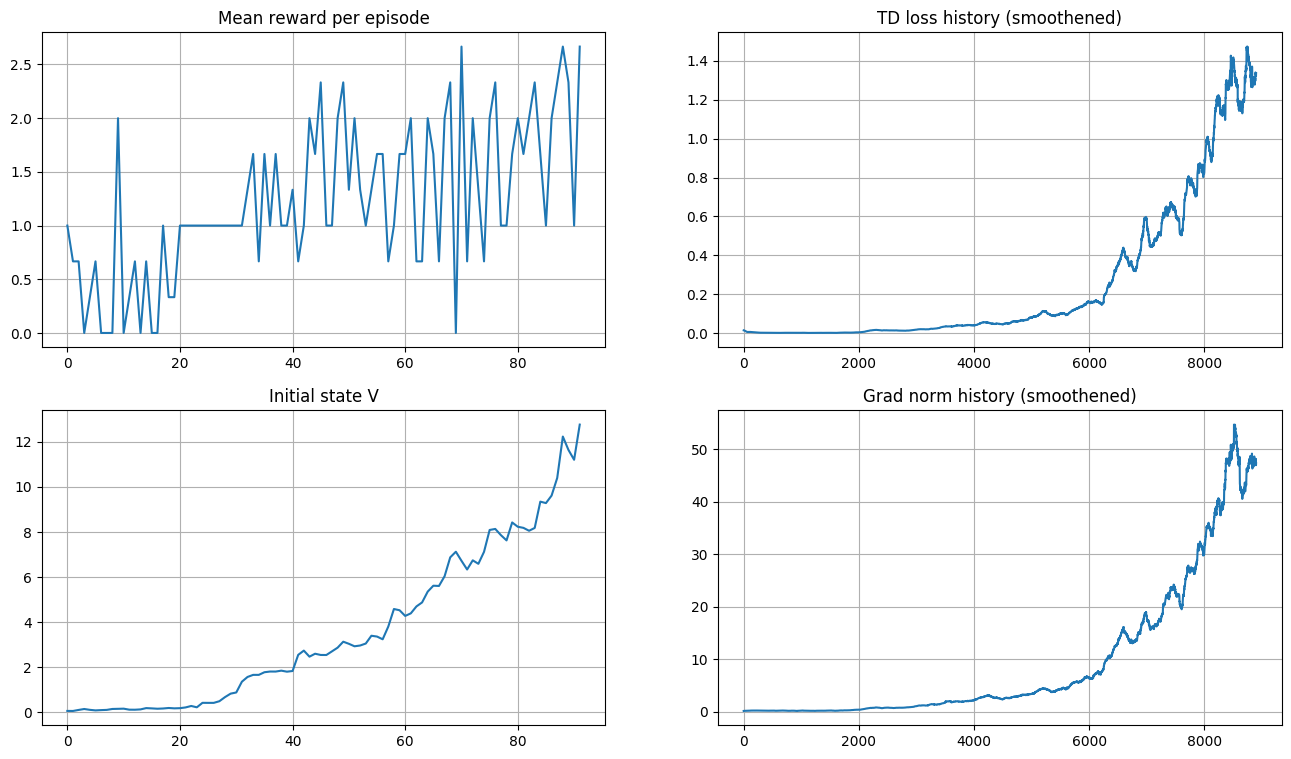

  8%|▊         | 225613/3000001 [1:57:43<24:07:39, 31.94it/s] 


KeyboardInterrupt: 

In [82]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print("less that 100 Mb RAM available, freezing")
        print("make sure everything is ok and make KeyboardInterrupt to continue")
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        weights,
        indices,
    ) = exp_replay.sample(batch_size)

    loss, td_error = compute_td_loss(
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        agent,
        target_network,
        weights,
        gamma=0.99,
        check_shapes=True,
    )  # < compute TD loss >

    exp_replay.update_priorities(indices, td_error)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        path = "priority_agent_" + str(step) + ".tar"
        torch.save({"agent_state_dict": agent.state_dict()}, path)
        # eval the agent
        cur_mean_reward = evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000
        )
        mean_rw_history.append(cur_mean_reward)
        initial_state_q_values = agent.get_qvalues([make_env(seed=step).reset()])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

        if cur_mean_reward > 3:
            break

In [83]:
final_score = (
    evaluate(
        make_env(clip_rewards=False, seed=9),
        agent,
        n_games=30,
        greedy=True,
        t_max=10 * 1000,
    )
    * n_lives
)
print("final score:", final_score)
assert final_score > 10, "not as cool as DQN can"
print("Cool!")

final score: 22.0
Cool!


# Quantile regression DQN

In [20]:
class QuantileDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0, quantiles=2):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.num_quantiles = quantiles
        # conv2d_size_out(conv2d_size_out(conv2d_size_out(64, 3, 2), 3, 2), 3, 2)
        # Define your network body here. Please make sure agent is fully contained here
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(3136, 256),
            nn.Linear(256, n_actions * self.num_quantiles),
        )

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = self.net(state_t).view(-1, self.n_actions, self.num_quantiles)

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy."""
        epsilon = self.epsilon
        batch_size, n_actions, n_quantiles = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.mean(2).argmax(1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1 - epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [58]:
agent = QuantileDQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

target_network = QuantileDQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(
    device
)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [171]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward."""
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            # return qvalues
            action = (
                qvalues[0].mean(1).argmax()
                if greedy
                else agent.sample_actions(qvalues)[0]
            )
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [172]:
evaluate(env, agent, n_games=1, greedy=True)

1.0

In [123]:
def huber(x, k=1.0):
    return torch.where(x.abs() < k, 0.5 * x.pow(2), k * (x.abs() - 0.5 * k))


def compute_huber_loss(
    states,
    actions,
    rewards,
    next_states,
    is_done,
    agent,
    target_network,
    tau,
    gamma=0.99,
    check_shapes=False,
    device=device,
):
    """Compute td loss using torch operations only. Use the formulae above."""
    states = torch.tensor(
        states, device=device, dtype=torch.float
    )  # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(
        actions, device=device, dtype=torch.long
    )  # shape: [batch_size]
    rewards = torch.tensor(
        rewards, device=device, dtype=torch.float
    )  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype("float32"), device=device, dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    batch_size = actions.size()[0]

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(batch_size), actions]

    # print(predicted_next_qvalues)

    # compute V*(next_states) using predicted next q-values

    next_state_values = predicted_next_qvalues[
        range(batch_size), predicted_next_qvalues.mean(2).max(1)[1]
    ]

    #    print(next_state_values)

    #    print(next_state_values)

    #   assert next_state_values.dim(
    #   ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.

    #  print(next_state_values)
    target_qvalues_for_actions = rewards.unsqueeze(
        1
    ) + gamma * next_state_values * is_not_done.unsqueeze(1)

    assert (
        target_qvalues_for_actions.requires_grad == False
    ), "do not send gradients to target!"

    # print(target_qvalues_for_actions)
    # print(predicted_qvalues_for_actions)

    diff = target_qvalues_for_actions - predicted_qvalues_for_actions
    loss = torch.mean(huber(diff) * (tau - (diff.detach() < 0).float()).abs())
    # loss = huber(diff) * (tau - (diff.detach() < 0).float()).abs()
    # loss = loss.mean()

    # mean squared error loss to minimize
    # loss = torch.mean((predicted_qvalues_for_actions -
    #                   target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

In [124]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10
)

loss = compute_huber_loss(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    tau,
    gamma=0.99,
    check_shapes=False,
)
loss.backward()

assert (
    loss.requires_grad and tuple(loss.data.size()) == ()
), "you must return scalar loss - mean over batch"
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "loss must be differentiable w.r.t. network weights"
assert np.all(
    next(target_network.parameters()).grad is None
), "target network should not have grads"

/tmp/ipykernel_2826570/2941548265.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.batch = np.array(list(self._storage.queue))[idx]


In [127]:
seed = 0xAB0BA
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [128]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = QuantileDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = QuantileDQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [129]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print(
            """
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
        )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [130]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

tau = torch.Tensor((2 * np.arange(2) + 1) / (2.0 * 2)).view(1, -1)
tau = tau.to(device)

max_grad_norm = 50

n_lives = 5

In [152]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

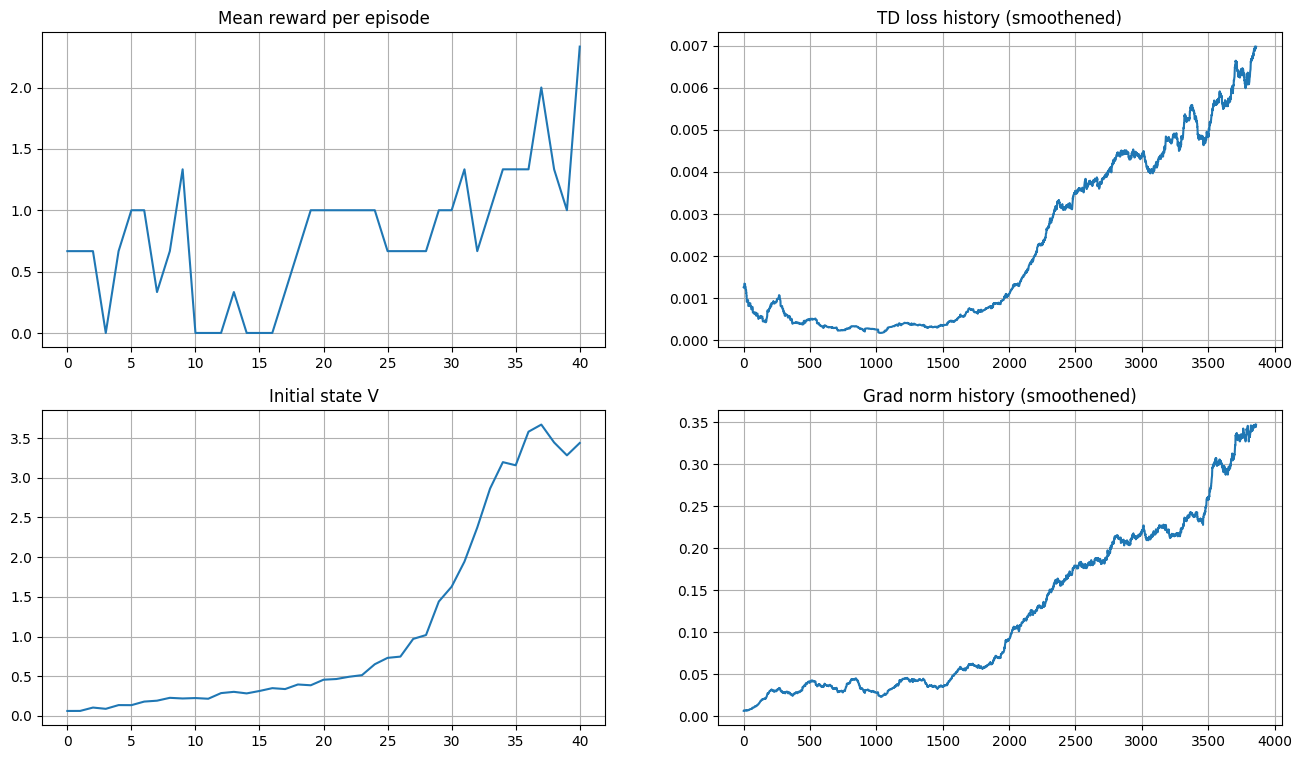

  6%|▌         | 185000/3000001 [1:04:53<16:27:23, 47.52it/s]


In [173]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print("less that 100 Mb RAM available, freezing")
        print("make sure everything is ok and make KeyboardInterrupt to continue")
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
    ) = exp_replay.sample(batch_size)

    loss = compute_huber_loss(
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        agent,
        target_network,
        tau,
        gamma=0.99,
        check_shapes=False,
    )

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        path = "quantile_agent_" + str(step) + ".tar"
        torch.save({"agent_state_dict": agent.state_dict()}, path)
        # eval the agent
        cur_mean_reward = evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000
        )
        mean_rw_history.append(cur_mean_reward)
        initial_state_q_values = agent.get_qvalues([make_env(seed=step).reset()])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

        if cur_mean_reward > 2:
            break

In [174]:
final_score = (
    evaluate(
        make_env(clip_rewards=False, seed=9),
        agent,
        n_games=30,
        greedy=True,
        t_max=10 * 1000,
    )
    * n_lives
)
print("final score:", final_score)
assert final_score > 10, "not as cool as DQN can"
print("Cool!")

final score: 12.0
Cool!
